In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# # Rain in Australia - Next-Day Prediction Model

Student name & ID: 

#Tala Kafafi    0197035
#Ayah Khawaldeh 0181117



# Project Overview


## Business Problem
Weather, and humankind's ability to accurately predict it, plays a critical role in many aspects of life. From farmers growing crops to a family planning a weekend vacation to logistical decision making within airlines, rain in particular is highly influential regarding plans. In some instances, the impact of rain can have large financial consequences. As a result, there is a strong interest from a plethora of stakeholders in the ability to accurately forecast rain. The goal of this project is to use the available data to create a next-day prediction model for whether or not it will rain. Such a model could be utilized in a weather app for the benefit of the public at large. 

# Imports & Settings


In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.9.1'

In [5]:
keras.__version__

'2.9.0'

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import numpy as np
np.random.seed(0)


import pandas as pd


# Exploratory Data Analysis

In [7]:
data = pd.read_csv("D:\c element\weatherAUS.csv\weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


## Column Definitions
According to the author of the Kaggle dataset and the ["Notes to accompany Daily Weather Observations"](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml) published by the Australian Bureau of Meteorology, the meanings and units for each of the columns in the dataset are as follows:

| **Column Name** | **Definition** | **Units** |
| --------------- | -------------- | --------- |
| `Date` | Date of the observation | N/A |
| `Location` | Location of the weather station | N/A |
| `MinTemp` | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `MaxTemp` | Maximum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `Rainfall` | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimeter | Millimeters |
| `Evaporation` | "Class A" pan evaporation in the 24 hours to 9am | Millimeters |
| `Sunshine` | Bright sunshine in the 24 hours to midnight | Hours |
| `WindGustDir` | Direction of the strongest wind gust in the 24 hours to midnight | 16 compass points |
| `WindGustSpeed` | Speed of the strongest wind gust in the 24 hours to midnight | Kilometers per hour |
| `WindDir9am` | Direction of the wind at 9am | 16 compass points |
| `WindDir3pm` | Direction of the wind at 3pm | 16 compass points |
| `WindSpeed9am` | Speed of the wind at 9am | Kilometers per hour |
| `WindSpeed3pm` | Speed of the wind at 3pm | Kilometers per hour |
| `Humidity9am` | Relative humidity at 9am | Percent |
| `Humidity3pm` | Relative humidity at 3pm | Percent |
| `Pressure9am` | Atmospheric pressure reduced to mean sea level at 9am | Hectopascals |
| `Pressure3pm` | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascals |
| `Cloud9am` | Fraction of sky obscured by cloud at 9am | Eighths |
| `Cloud3pm` | Fraction of sky obscured by cloud at 3pm | Eighths |
| `Temp9am` | Temparature at 9am | Degrees Celsius |
| `Temp3pm` | Temparature at 3am | Degrees Celsius |
| `RainToday` | Did the current day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |
| `RainTomorrow` | Did the next day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |

# Exploration

# Summary Info and Stats
Taking a look at the dataframe info:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [9]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
MinTemp,141556.0,12.186400,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustSpeed,132923.0,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,140845.0,14.001988,8.893337,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,139563.0,18.637576,8.803345,0.0,13.0,19.0,24.0,87.0
Humidity9am,140419.0,68.843810,19.051293,0.0,57.0,70.0,83.0,100.0
Humidity3pm,138583.0,51.482606,20.797772,0.0,37.0,52.0,66.0,100.0


# Histograms

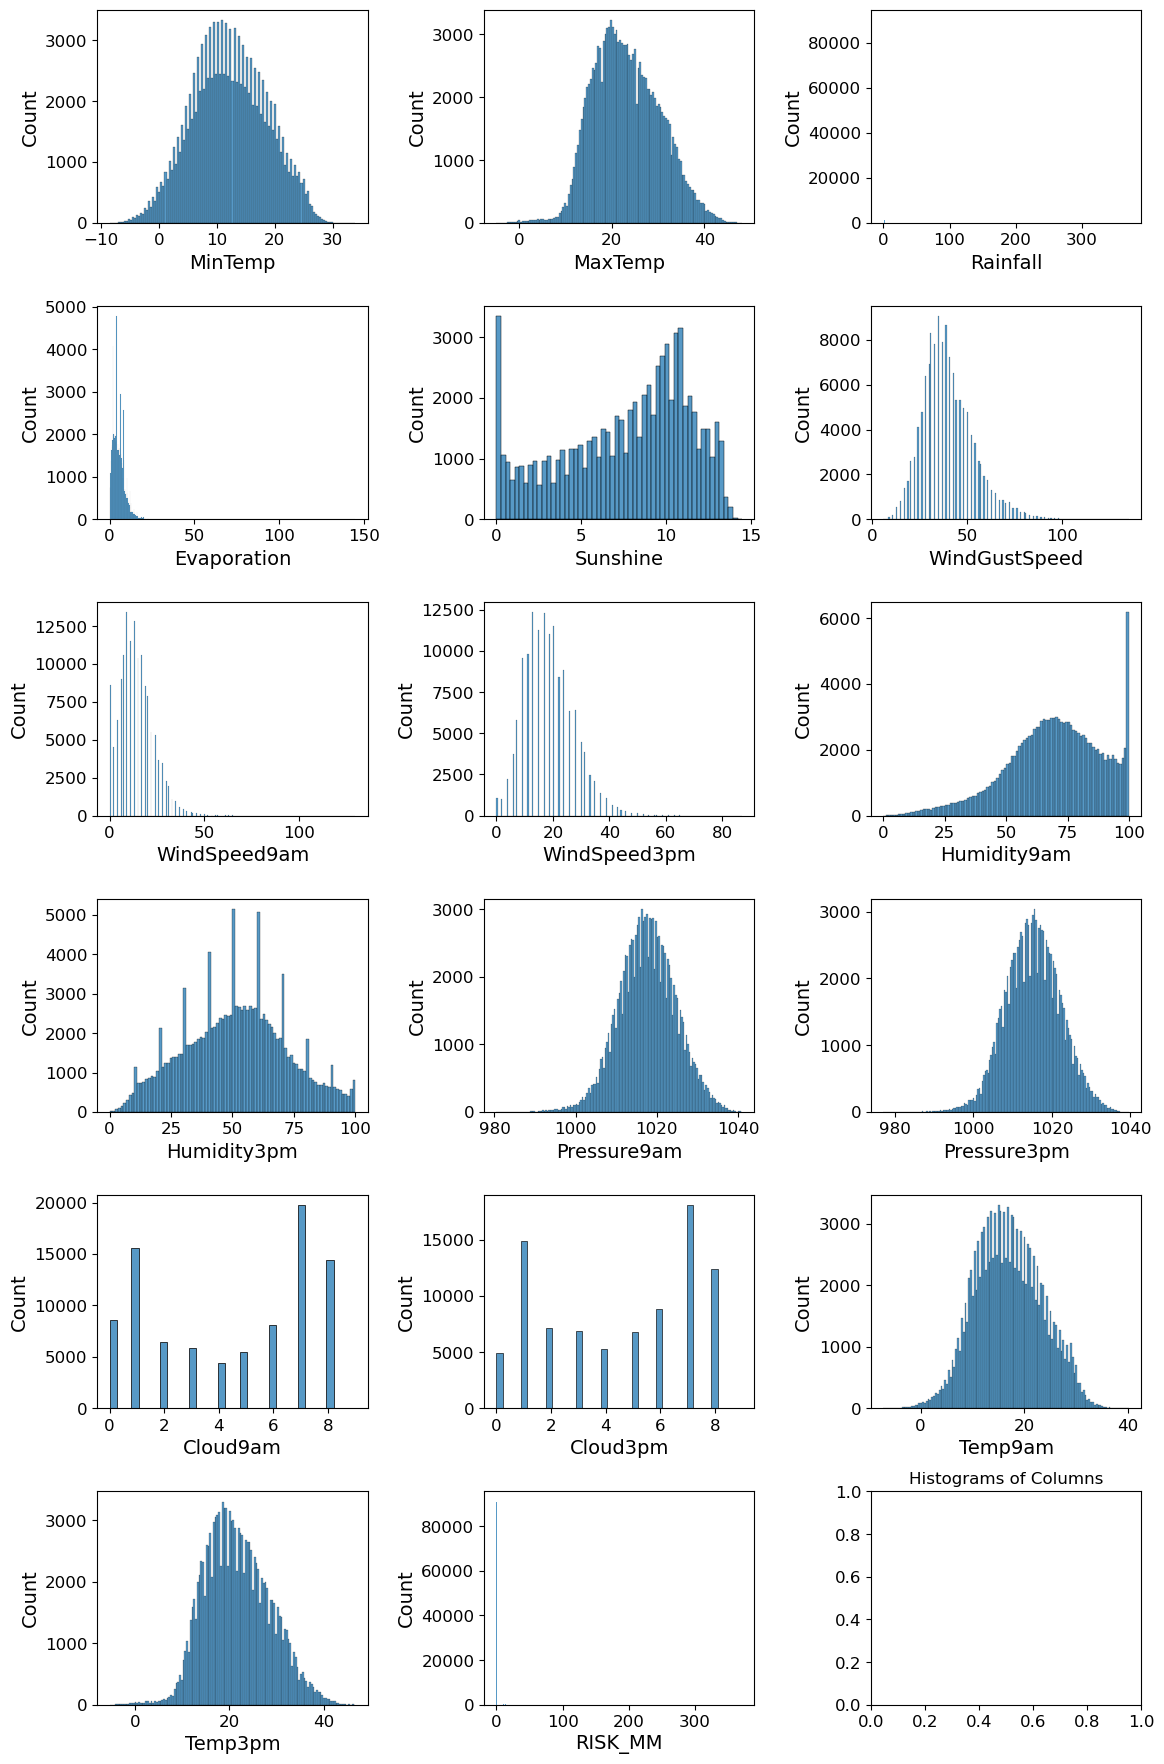

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18))
axes = axes.reshape(-1)

continuous = [col for col in data.columns if data[col].dtype != object]
for i, col in enumerate(continuous):
    sns.histplot(data[col], ax=axes[i])

fig.tight_layout(pad=2.0)
plt.title('Histograms of Columns')
plt.savefig('images/histograms.png', facecolor='white', dpi=100);

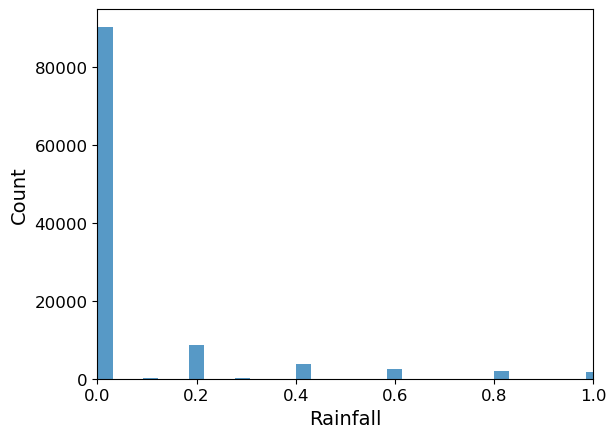

In [11]:
sns.histplot(data.Rainfall)
plt.xlim(0, 1);

# Correlation Matrix

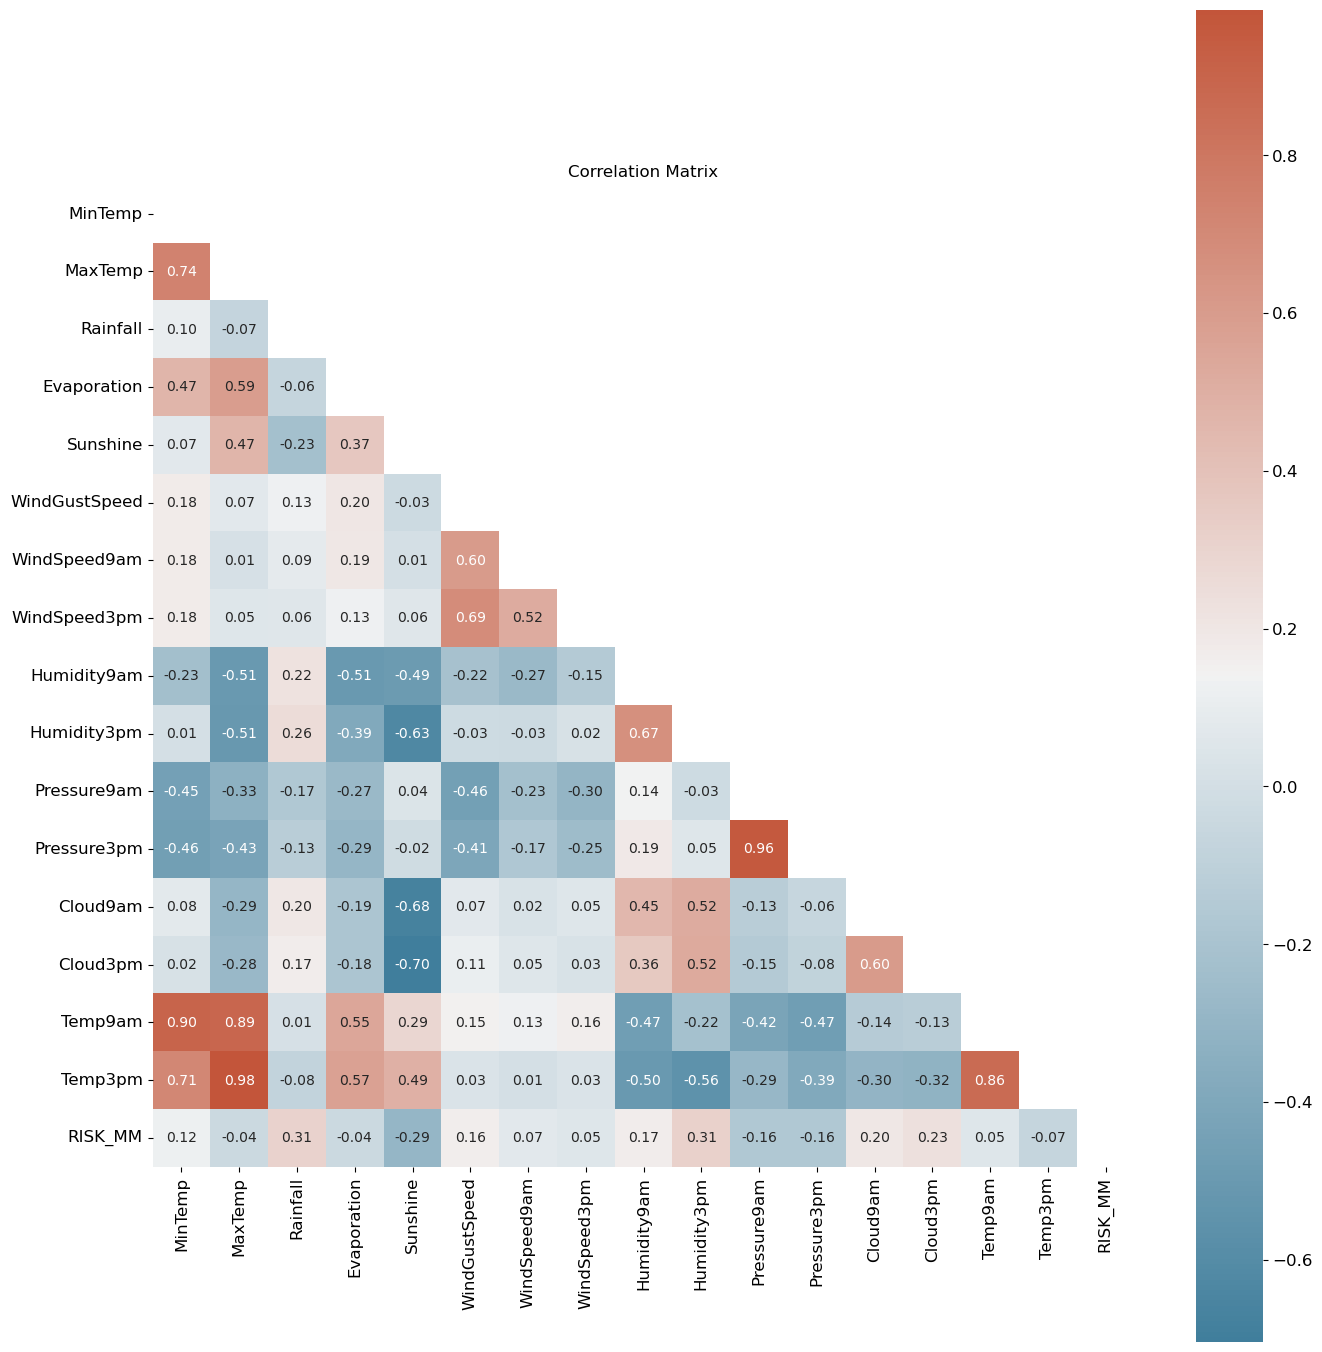

In [12]:
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(data.corr()))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100);

# **Observations:**
- Nothing in this correlation heatmap is surprising
- Features with strong correlations (either positive or negative) have intuitive reasons for being so

 11.0    883
 9.6     883
 10.2    880
 10.5    867
 10.8    860
        ... 
 30.5      1
-7.3       1
-7.8       1
-7.2       1
 30.2      1
Name: MinTemp, Length: 389, dtype: int64


<AxesSubplot:>

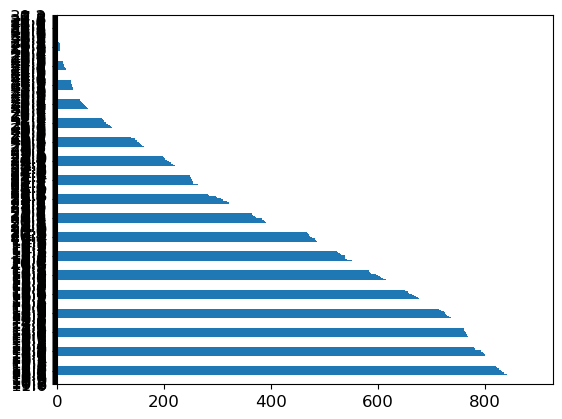

In [13]:
 status=data['MinTemp'].value_counts()
print(status)
status.plot(kind='barh')

In [14]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']


In [15]:
t = (data.dtypes == "object")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64


<AxesSubplot:>

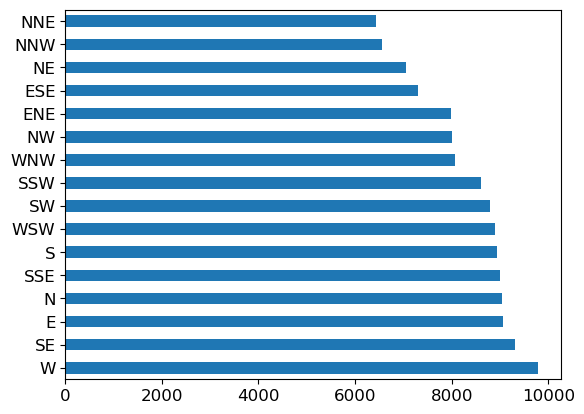

In [16]:
status=data['WindGustDir'].value_counts()
print(status)
status.plot(kind='barh')

49


<AxesSubplot:>

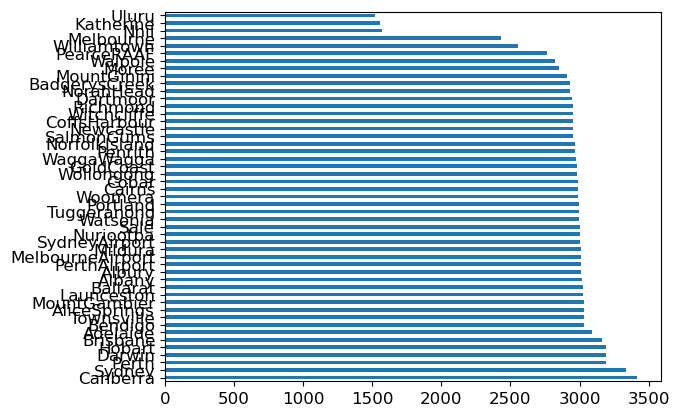

In [17]:
status=data['Location'].value_counts()
print(status.count())
status.plot(kind='barh')

# spil the date into years and months and days

# Extracting the Month
 the EDA section, rainfall in Australia exhibits seasonality. Instead of using the full date from the `Date` column, extracting just the month is much more valuable.

In [18]:
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

In [19]:
data['month'] = data.Date.dt.month
#data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
#data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,year,month,day
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,8.0,NaN,16.9,21.8,No,0.0,No,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,NaN,NaN,17.2,24.3,No,0.0,No,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,NaN,2.0,21.0,23.2,No,0.0,No,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,NaN,NaN,18.1,26.5,No,1.0,No,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,7.0,8.0,17.8,29.7,No,0.2,No,2008,12,5


In [20]:
data.corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,year,month,day
MinTemp,1.000000,0.736267,0.104255,0.467261,0.072961,0.177285,0.176005,0.175749,-0.234211,0.005999,-0.451260,-0.461623,0.077625,0.020489,0.901813,0.708865,0.124743,0.039245,-0.204279,0.001507
MaxTemp,0.736267,1.000000,-0.074839,0.588915,0.469967,0.067690,0.014680,0.050800,-0.505432,-0.509270,-0.332293,-0.427279,-0.289865,-0.279053,0.887020,0.984562,-0.044208,0.058388,-0.164622,-0.000495
Rainfall,0.104255,-0.074839,1.000000,-0.064549,-0.227525,0.133497,0.086816,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.011477,-0.079178,0.308557,-0.009284,-0.030863,0.001134
Evaporation,0.467261,0.588915,-0.064549,1.000000,0.366607,0.203001,0.193936,0.128895,-0.505890,-0.392785,-0.269907,-0.293160,-0.185032,-0.184287,0.545497,0.574275,-0.043498,0.084141,-0.027912,-0.007770
Sunshine,0.072961,0.469967,-0.227525,0.366607,1.000000,-0.032831,0.008040,0.056012,-0.491603,-0.629122,0.040959,-0.020464,-0.675610,-0.704202,0.291139,0.490180,-0.294973,0.011678,0.023885,-0.001173
WindGustSpeed,0.177285,0.067690,0.133497,0.203001,-0.032831,1.000000,0.604837,0.686419,-0.215461,-0.026663,-0.457891,-0.412922,0.071235,0.109088,0.150258,0.032970,0.162923,-0.032708,0.060918,-0.009226
WindSpeed9am,0.176005,0.014680,0.086816,0.193936,0.008040,0.604837,1.000000,0.519971,-0.270807,-0.031607,-0.227923,-0.174916,0.024280,0.053584,0.129298,0.005108,0.069404,-0.021620,0.051039,-0.009183
WindSpeed3pm,0.175749,0.050800,0.057759,0.128895,0.056012,0.686419,0.519971,1.000000,-0.145942,0.015903,-0.295567,-0.254988,0.052780,0.025269,0.163601,0.028567,0.049240,-0.032806,0.061006,-0.009969
Humidity9am,-0.234211,-0.505432,0.223725,-0.505890,-0.491603,-0.215461,-0.270807,-0.145942,1.000000,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777,0.172417,0.010708,-0.090564,0.015610
Humidity3pm,0.005999,-0.509270,0.255312,-0.392785,-0.629122,-0.026663,-0.031607,0.015903,0.667388,1.000000,-0.027449,0.051840,0.517037,0.523270,-0.221467,-0.557989,0.313183,-0.009150,-0.018541,0.013207


# handling the missing data

In [21]:
data.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
year                 0
month                0
day                  0
dtype: int64

<AxesSubplot:>

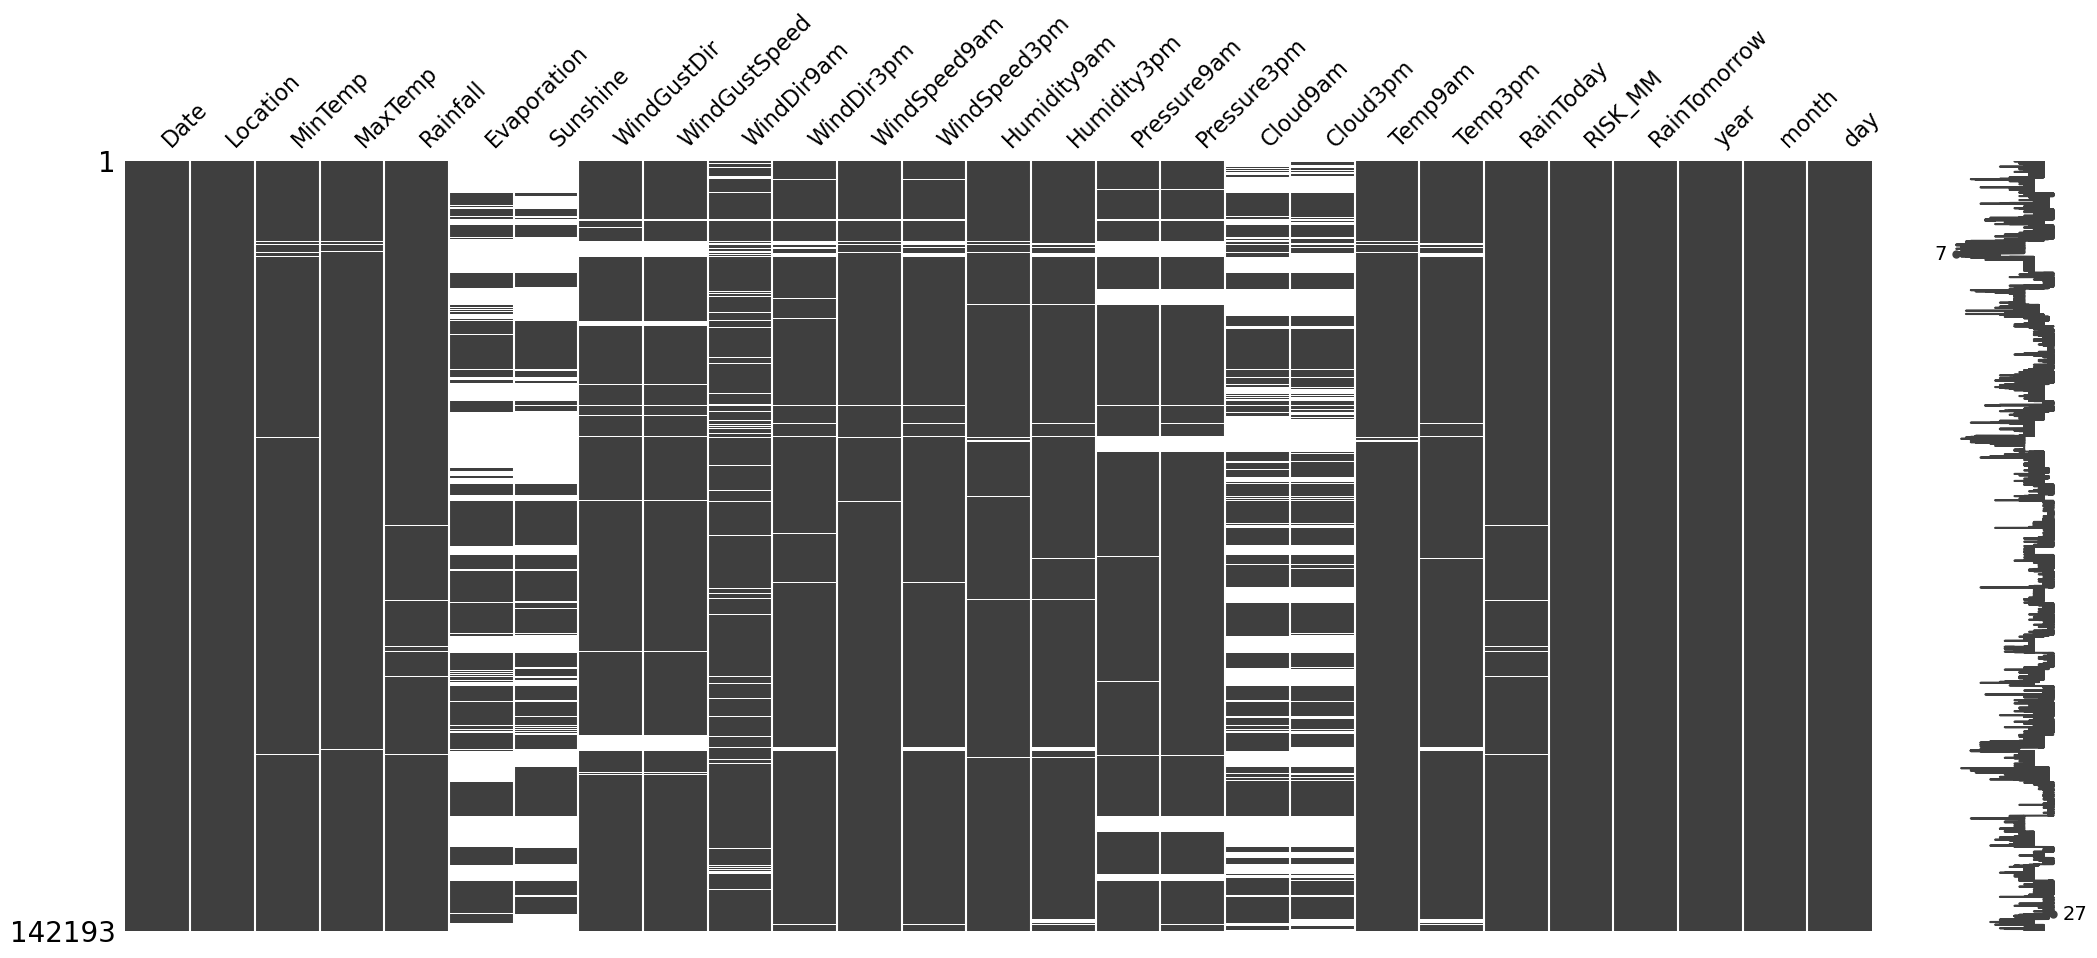

In [22]:
#!pip install missingno
import missingno as msno
msno.matrix(data)

In [23]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [24]:
for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [25]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RISK_MM']


In [26]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

<AxesSubplot:>

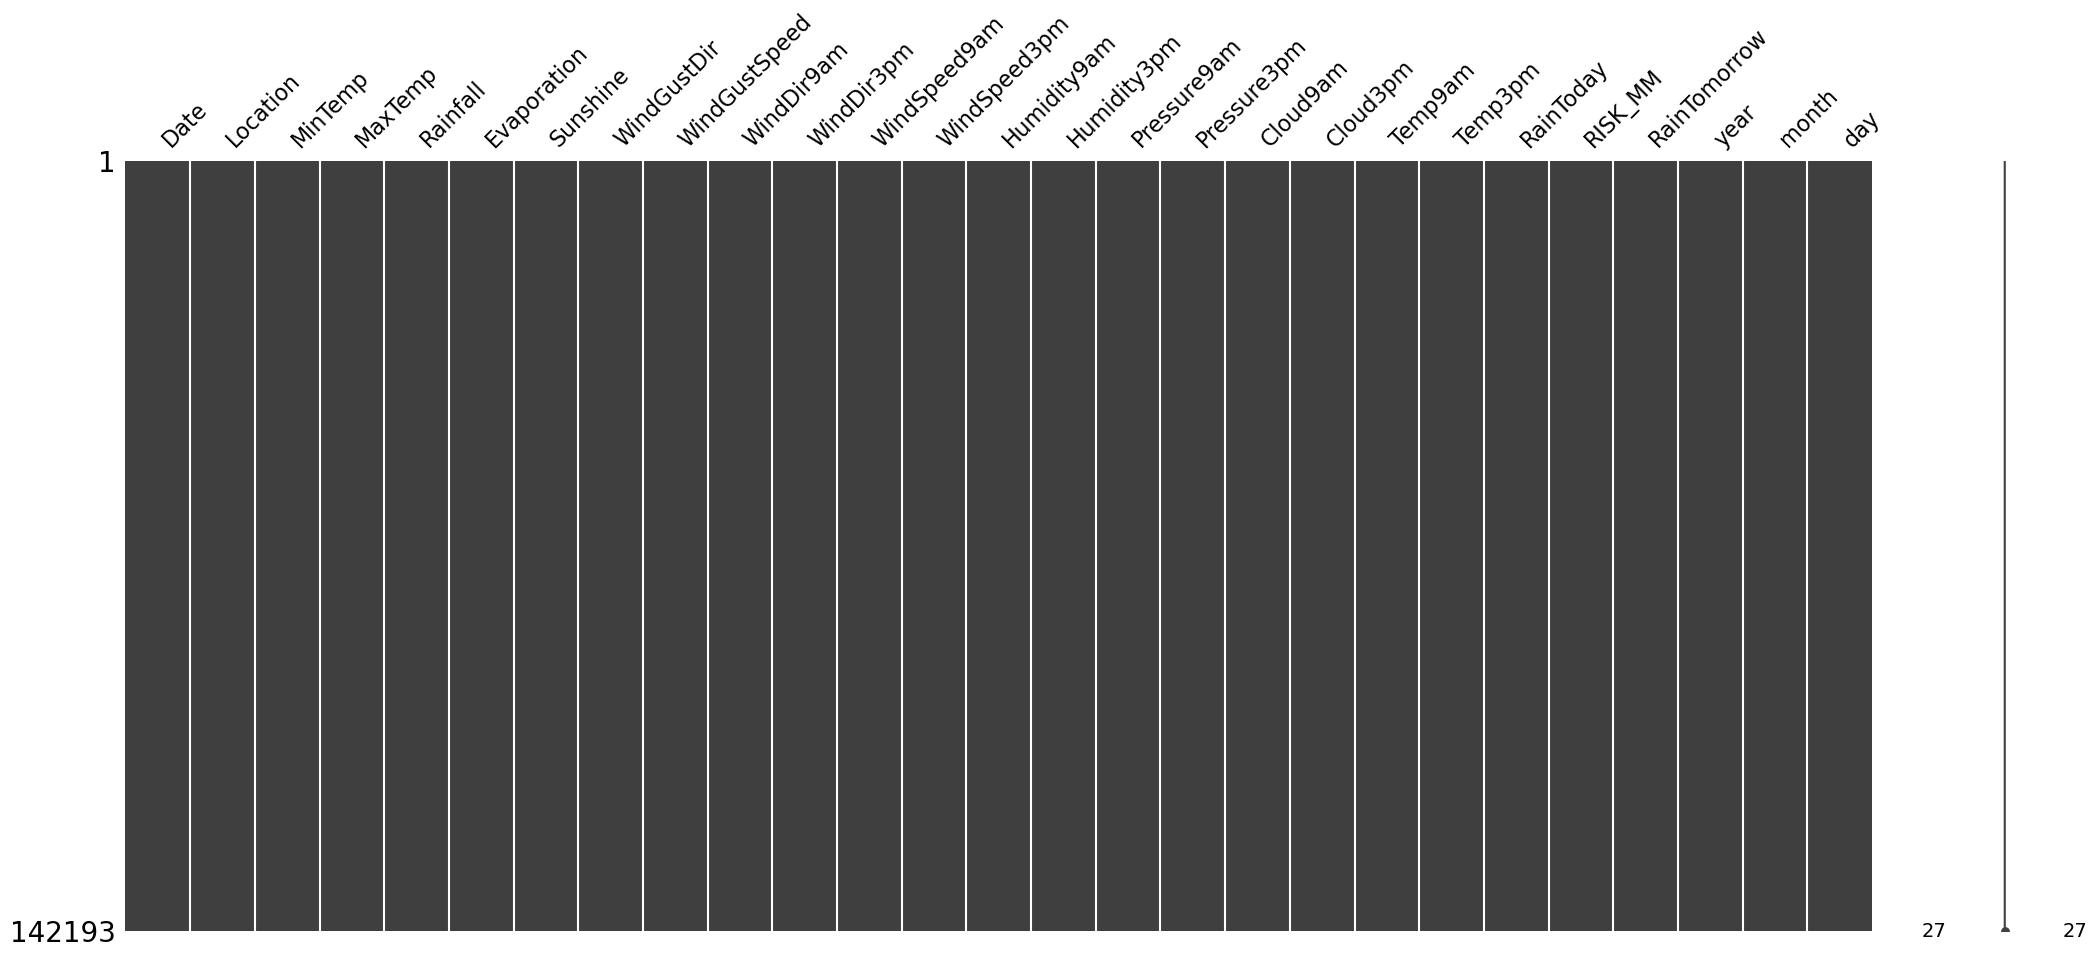

In [27]:
msno.matrix(data)

In [28]:
status=data['WindGustDir'].value_counts()
print(status)

W      19110
SE      9309
E       9071
N       9033
SSE     8993
S       8949
WSW     8901
SW      8797
SSW     8610
WNW     8066
NW      8003
ENE     7992
ESE     7305
NE      7060
NNW     6561
NNE     6433
Name: WindGustDir, dtype: int64


# for encoding i will use label encoder that encode based on alphabetical order , it better than onehotencoder because of the large varity in the values

In [29]:
# Apply label encoder to each column with categorical data
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    

In [30]:
status=data['WindGustDir'].value_counts()
print(status)

13    19110
9      9309
0      9071
3      9033
10     8993
8      8949
15     8901
12     8797
11     8610
14     8066
7      8003
1      7992
2      7305
4      7060
6      6561
5      6433
Name: WindGustDir, dtype: int64


# as we see all values became numarical

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  int32         
 2   MinTemp        142193 non-null  float64       
 3   MaxTemp        142193 non-null  float64       
 4   Rainfall       142193 non-null  float64       
 5   Evaporation    142193 non-null  float64       
 6   Sunshine       142193 non-null  float64       
 7   WindGustDir    142193 non-null  int32         
 8   WindGustSpeed  142193 non-null  float64       
 9   WindDir9am     142193 non-null  int32         
 10  WindDir3pm     142193 non-null  int32         
 11  WindSpeed9am   142193 non-null  float64       
 12  WindSpeed3pm   142193 non-null  float64       
 13  Humidity9am    142193 non-null  float64       
 14  Humidity3pm    142193 non-null  float64       
 15  

In [32]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,142193.0,-2.375395e-14,1.000004,-1.667479,-0.894869,0.018216,0.861063,1.703910
MinTemp,142193.0,-2.535704e-16,1.000004,-3.237728,-0.717738,-0.029045,0.722257,3.398768
MaxTemp,142193.0,-1.206704e-14,1.000004,-3.941909,-0.749039,-0.087961,0.699708,3.498743
Rainfall,142193.0,-2.226648e-14,1.000004,-0.276125,-0.276125,-0.276125,-0.204920,43.752188
Evaporation,142193.0,1.492205e-14,1.000004,-1.627183,-0.371450,-0.120303,0.068057,43.893144
Sunshine,142193.0,1.011420e-15,1.000004,-2.903725,0.056962,0.165280,0.237492,2.331636
WindGustDir,142193.0,2.435278e-14,1.000004,-1.716789,-0.864683,0.200450,1.052556,1.478609
WindGustSpeed,142193.0,2.053144e-14,1.000004,-2.581325,-0.678822,-0.070021,0.462679,7.235589
WindDir9am,142193.0,3.042395e-14,1.000004,-1.550574,-0.886072,-0.000070,0.885932,1.771934
WindDir3pm,142193.0,-5.629434e-15,1.000004,-1.713146,-0.833311,0.046525,0.926360,1.586236


In [33]:
features["RainTomorrow"] = target

In [34]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(142193, 23)

# the model that is applied in the  documentation

In [35]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 23))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2844/2844 [==============================] - 12s 4ms/step - loss: 0.4387 - accuracy: 0.8059 - val_loss: 0.2957 - val_accuracy: 0.9057
Epoch 2/150
2844/2844 [==============================] - 10s 3ms/step - loss: 0.2352 - accuracy: 0.9249 - val_loss: 0.0701 - val_accuracy: 0.9776
Epoch 3/150
2844/2844 [==============================] - 10s 3ms/step - loss: 0.1004 - accuracy: 0.9683 - val_loss: 0.0193 - val_accuracy: 0.9936
Epoch 4/150
2844/2844 [==============================] - 10s 3ms/step - loss: 0.0660 - accuracy: 0.9779 - val_loss: 0.0112 - val_accuracy: 0.9957
Epoch 5/150
2844/2844 [==============================] - 10s 3ms/step - loss: 0.0527 - accuracy: 0.9822 - val_loss: 0.0051 - val_accuracy: 0.9993
Epoch 6/150
2844/2844 [==============================] - 10s 3ms/step - loss: 0.0466 - accuracy: 0.9832 - val_loss: 0.0038 - val_accuracy: 0.9991
Epoch 7/150
2844/2844 [==============================] - 10s 4ms/step - loss: 0.0431 - accuracy: 0.9837 - val_loss: 0.0023 -

# Plotting training and validation loss over epochs

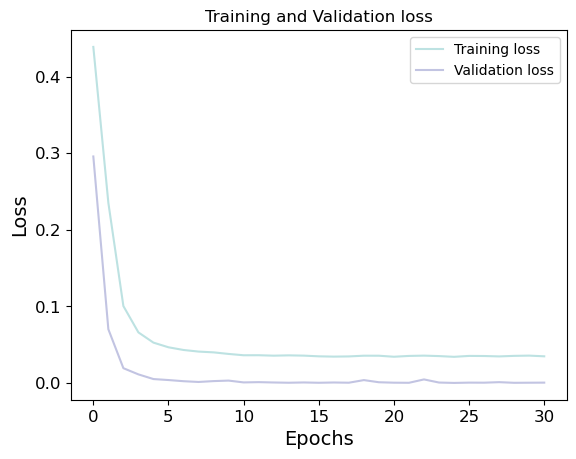

In [36]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# Plotting training and validation accuracy over epochs

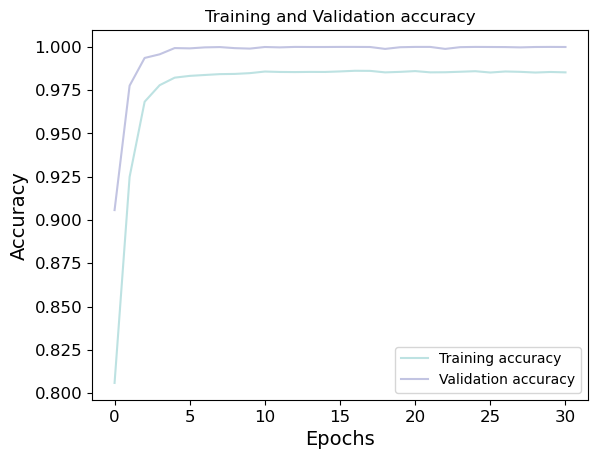

In [37]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# CONCLUSIONS
Concluding the model with:

Testing on the test set
Evaluating the confusion matrix
Evaluating the classification report

In [38]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

889/889 [==============================] - 1s 1ms/step


<AxesSubplot:>

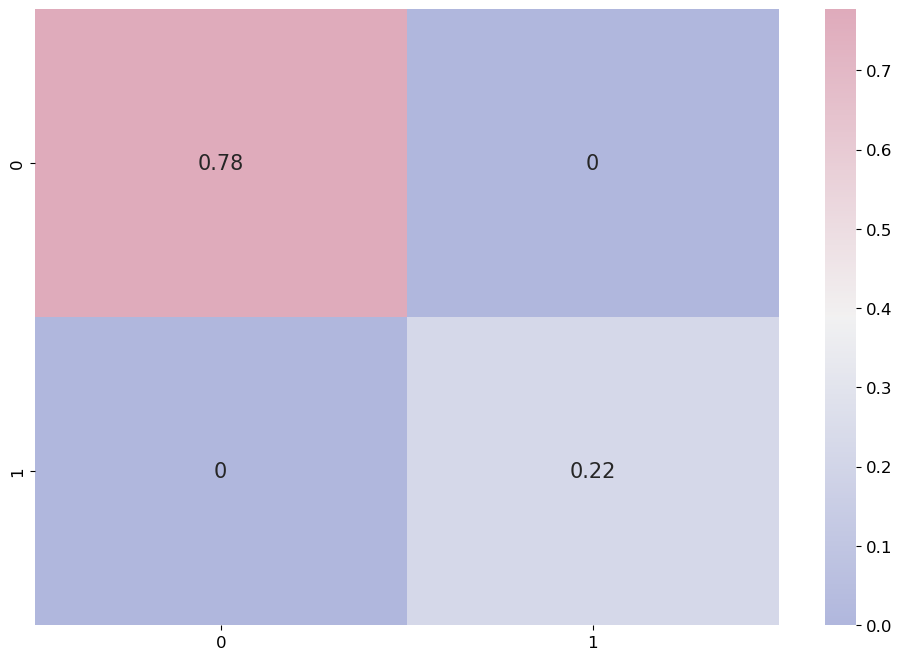

In [39]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22098
           1       1.00      1.00      1.00      6341

    accuracy                           1.00     28439
   macro avg       1.00      1.00      1.00     28439
weighted avg       1.00      1.00      1.00     28439



# some info about the model 

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9

In [42]:
model.layers

# Compiling , training and evaluation the data 
we call compile() method after greating the model to specify the loss function and the optimizer to use.
after compiling the model will be ready to be trained. For this we simply need to call its fit()method

# validation set

 We also pass a validation set
(this is optional): Keras will measure the loss and the extra metrics on this set at the
end of each epoch, which is very useful to see how well the model really performs: if
the performance on the training set is much better than on the validation set,  the model is probably overfitting the training set  
we pass the validation set through the fit method by using validation_split argument or validation data (If both validation_data and validation_split are provided, validation_data will override validation_split)
If you use validation_data option, you need to prepare the validataion data and train data seperately. Afterwards, the validation_split option allows you to merely input whole bunch of data and split it inside. 

# optimizer

During the training process, we tweak and change the parameters (weights) of our model to try and minimize that loss function, and make our predictions as correct and optimized as possible that is done by using optimizer 
optimizers shape and mold your model into its most accurate possible form. The loss function is to guide the optimizer, telling the optimizer when it’s moving in the right or wrong direction.

# lets try diffrent optimizers

in the model in the  documentation​ the optimizer that is used is Adam optimizer with learning rante = .00009 which wasw fast and provid ggood accuracy .

# SGD optimizer

In [43]:
model.compile(optimizer = "sgd", loss = 'binary_crossentropy', metrics = ['accuracy'])
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.1018 - accuracy: 0.9709 - val_loss: 0.0252 - val_accuracy: 0.9903
Epoch 2/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0673 - accuracy: 0.9749 - val_loss: 0.0234 - val_accuracy: 0.9907
Epoch 3/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0593 - accuracy: 0.9772 - val_loss: 0.0212 - val_accuracy: 0.9913
Epoch 4/150
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0592 - accuracy: 0.9769 - val_loss: 0.0308 - val_accuracy: 0.9873
Epoch 5/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0571 - accuracy: 0.9774 - val_loss: 0.0210 - val_accuracy: 0.9913
Epoch 6/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0561 - accuracy: 0.9770 - val_loss: 0.0106 - val_accuracy: 0.9954
Epoch 7/150
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0530 - accuracy: 0.9785 - val_loss: 0.0280 - val_ac

 The fit() method returns a History object containing the training parameters (his
tory.params) and a dictionary (history.history) containing the loss and extra metrics it 
measured at the end of each epoch on the training set and on the validation set
that is usful to observieing ans compareind  the values of loss  and acuuracy for each training set and validtaion set

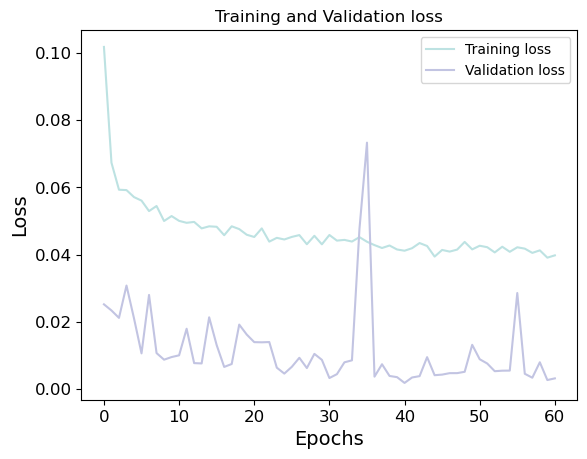

In [44]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

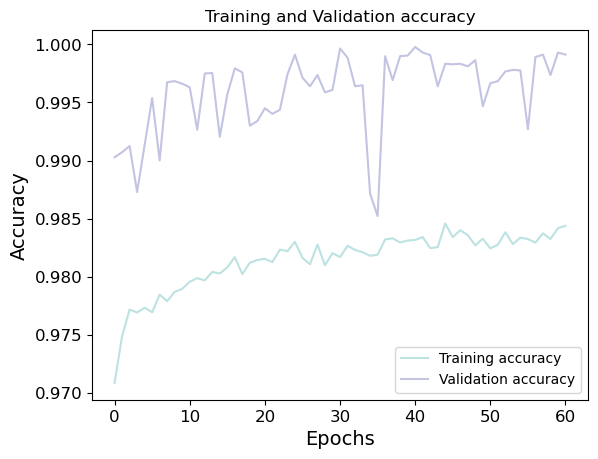

In [45]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Momentum optimization

In [46]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [47]:
model.compile(optimizer = optimizer , loss = 'binary_crossentropy', metrics = ['accuracy'])
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2844/2844 [==============================] - 7s 2ms/step - loss: 0.0417 - accuracy: 0.9835 - val_loss: 0.0029 - val_accuracy: 0.9993
Epoch 2/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0389 - accuracy: 0.9843 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 3/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0375 - accuracy: 0.9850 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 4/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0352 - accuracy: 0.9855 - val_loss: 8.8669e-04 - val_accuracy: 0.9999
Epoch 5/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0359 - accuracy: 0.9853 - val_loss: 9.0022e-04 - val_accuracy: 1.0000
Epoch 6/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0362 - accuracy: 0.9847 - val_loss: 7.0440e-04 - val_accuracy: 0.9999
Epoch 7/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0351 - accuracy: 0.9856 - val_loss: 0.0

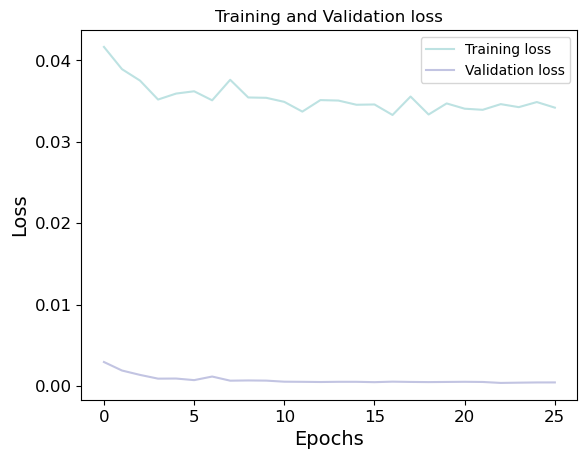

In [48]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

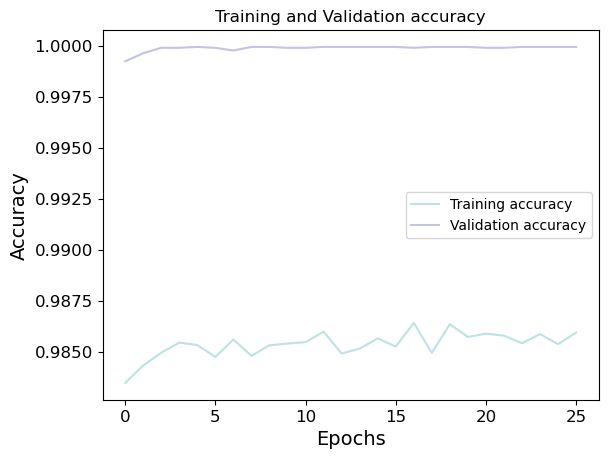

In [49]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Nesterov Accelerated Gradient

In [50]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer = optimizer , loss = 'binary_crossentropy', metrics = ['accuracy'])
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0483 - accuracy: 0.9823 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 2/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0427 - accuracy: 0.9828 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 3/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0420 - accuracy: 0.9826 - val_loss: 0.0132 - val_accuracy: 0.9956
Epoch 4/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0434 - accuracy: 0.9828 - val_loss: 0.0091 - val_accuracy: 0.9960
Epoch 5/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0422 - accuracy: 0.9825 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 6/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0437 - accuracy: 0.9821 - val_loss: 0.0151 - val_accuracy: 0.9942
Epoch 7/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0410 - accuracy: 0.9833 - val_loss: 0.0066 - val_ac

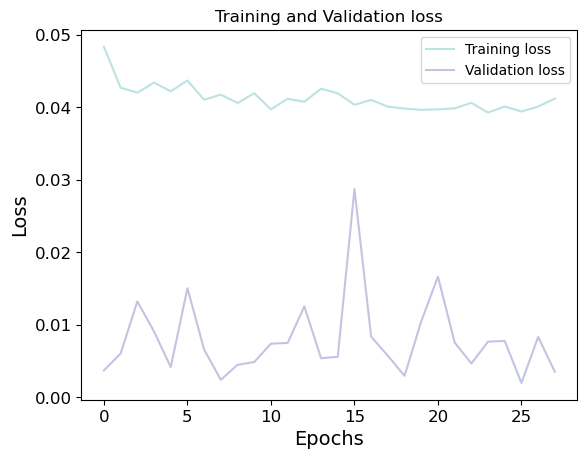

In [51]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

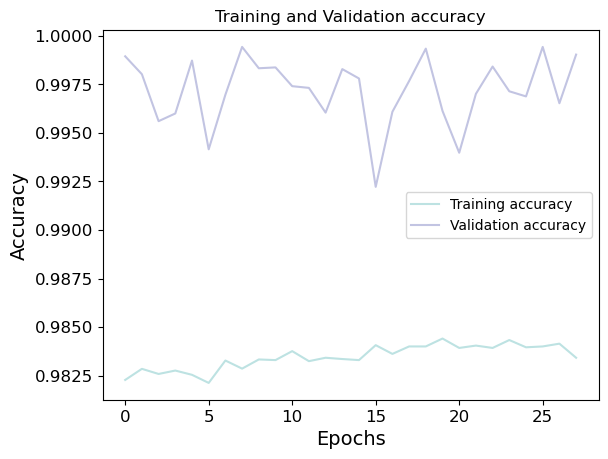

In [52]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Observation:
    - Adam & Momentum optimizater provide the best performance 

# Callbacks 

The fit() method accepts a callbacks argument that lets you specify a list of objects
that Keras will call during training
*using callback with setting  save_best_only=True that will  only save your model when its performance on the validation set is the best so far
*using EarlyStopping actually interrupt training early
when there is no more progress (to avoid wasting time and resources)

# lest try not using callback with earlly stopping 

In [53]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150,  validation_split=0.2)

Epoch 1/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0405 - accuracy: 0.9831 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 2/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0407 - accuracy: 0.9834 - val_loss: 0.0121 - val_accuracy: 0.9949
Epoch 3/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0421 - accuracy: 0.9830 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 4/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0389 - accuracy: 0.9847 - val_loss: 0.0134 - val_accuracy: 0.9958
Epoch 5/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0418 - accuracy: 0.9833 - val_loss: 0.0131 - val_accuracy: 0.9949
Epoch 6/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0400 - accuracy: 0.9843 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 7/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0407 - accuracy: 0.9833 - val_loss: 0.0080 - val_ac

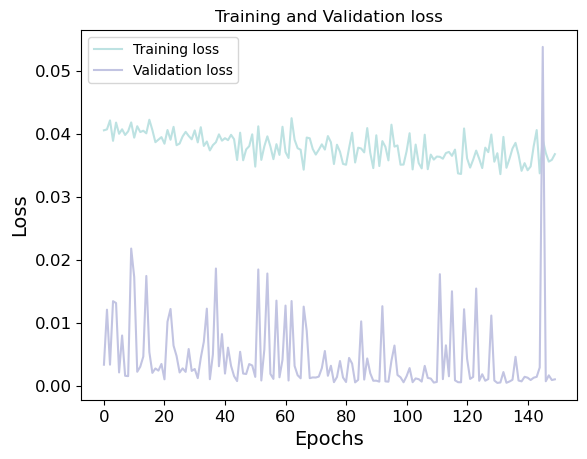

In [54]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

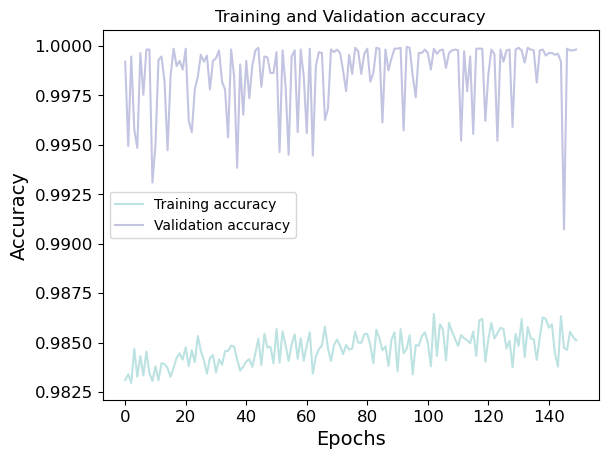

In [55]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Observation:

    - it is talked a lot of time and and there is an overfitting occurred

# ModelCheckpoint 
it will only save your model when its performance on the validation set is the best so far. This
way, you do not need to worry about training for too long and overfitting the training
set: simply restore the last model saved after training, and this will be the best model
on the validation set

In [56]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train,
                    batch_size = 32, epochs = 150,  validation_split=0.2,
                    callbacks=[checkpoint_cb])
bestmodel = keras.models.load_model("my_keras_model.h5") # rollback to best model

Epoch 1/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0108 - val_loss: 1.5498e-04
Epoch 2/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0110 - val_loss: 1.4794e-04
Epoch 3/150
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0116 - val_loss: 1.4844e-04
Epoch 4/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0109 - val_loss: 1.5055e-04
Epoch 5/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0107 - val_loss: 1.5025e-04
Epoch 6/150
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0114 - val_loss: 1.5112e-04
Epoch 7/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0110 - val_loss: 1.5084e-04
Epoch 8/150
2844/2844 [==============================] - 6s 2ms/step - loss: 0.0107 - val_loss: 1.5095e-04
Epoch 9/150
2844/2844 [==============================] - 5s 2ms/step - loss: 0.0110 - val_loss: 1.4910e-04
Epoch 10/150
2844/2844 [=============

# evaliuating the model 

In [57]:
model.evaluate(X_test, y_test)


889/889 [==============================] - 1s 1ms/step - loss: 2.0938e-05


2.0938481611665338e-05

# Avoiding Overfitting Through Regularization

we already use droupout in the first model and it is do the following 
at every training step, every neuron (including the
input neurons, but always excluding the output neurons) has a probability p of being
temporarily “dropped out,” meaning it will be entirely ignored during this training
step, but it may be active during the next step

In [109]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 23,kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid',kernel_regularizer=keras.regularizers.l2(0.01)))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 26, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
3501/3501 [==============================] - 8s 2ms/step - loss: 0.5131 - accuracy: 0.7748 - val_loss: 0.3976 - val_accuracy: 0.7783
Epoch 2/150
3501/3501 [==============================] - 6s 2ms/step - loss: 0.4125 - accuracy: 0.8817 - val_loss: 0.3656 - val_accuracy: 0.9193
Epoch 3/150
3501/3501 [==============================] - 6s 2ms/step - loss: 0.3863 - accuracy: 0.9216 - val_loss: 0.3378 - val_accuracy: 0.9398
Epoch 4/150
3501/3501 [==============================] - 7s 2ms/step - loss: 0.3635 - accuracy: 0.9414 - val_loss: 0.3127 - val_accuracy: 0.9561
Epoch 5/150
3501/3501 [==============================] - 8s 2ms/step - loss: 0.3440 - accuracy: 0.9558 - val_loss: 0.2977 - val_accuracy: 0.9641
Epoch 6/150
3501/3501 [==============================] - 7s 2ms/step - loss: 0.3328 - accuracy: 0.9633 - val_loss: 0.2879 - val_accuracy: 0.9688
Epoch 7/150
3501/3501 [==============================] - 8s 2ms/step - loss: 0.3255 - accuracy: 0.9658 - val_loss: 0.2795 - val_ac

# learning Scheduling

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [112]:
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 23))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[lr_scheduler], validation_split=0.2)

Epoch 1/150
2844/2844 [==============================] - 8s 3ms/step - loss: 0.4172 - accuracy: 0.8274 - val_loss: 0.2222 - val_accuracy: 0.9321 - lr: 9.0000e-05
Epoch 2/150
2844/2844 [==============================] - 8s 3ms/step - loss: 0.1700 - accuracy: 0.9172 - val_loss: 0.0409 - val_accuracy: 0.9889 - lr: 9.0000e-05
Epoch 3/150
2844/2844 [==============================] - 7s 3ms/step - loss: 0.0876 - accuracy: 0.9737 - val_loss: 0.0155 - val_accuracy: 0.9953 - lr: 9.0000e-05
Epoch 4/150
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0669 - accuracy: 0.9802 - val_loss: 0.0107 - val_accuracy: 0.9971 - lr: 9.0000e-05
Epoch 5/150
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0571 - accuracy: 0.9822 - val_loss: 0.0087 - val_accuracy: 0.9973 - lr: 9.0000e-05
Epoch 6/150
2844/2844 [==============================] - 8s 3ms/step - loss: 0.0507 - accuracy: 0.9833 - val_loss: 0.0053 - val_accuracy: 0.9986 - lr: 9.0000e-05
Epoch 7/150
2844/2844 [=====

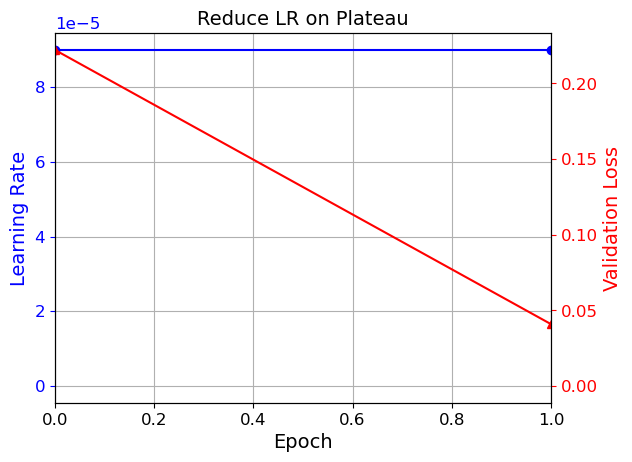

In [113]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

references :

    https://www.kaggle.com/code/karnikakapoor/rain-prediction-ann
    
    https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy